```
Copyright 2021 Twitter, Inc.
SPDX-License-Identifier: Apache-2.0
```

# Image Annotation dashboard

This notebook sets up a server with API access of the cropping algorithm. 

At the end of this notebook, a url will be given and you can open that link in the browser to access the cropping algorithm API. 

On that webpage, you can upload any image and the saliency-based crops will be produced.

Make sure dash is install.

In [1]:
import base64
import logging
import shlex
import subprocess
import sys
import tempfile
from collections import namedtuple
from io import BytesIO
from pathlib import Path

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from PIL import Image

import re

logging.basicConfig(level=logging.ERROR)

In [2]:
import datetime
import os

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State

PORT = 9000  
DEV_PORT = 9001
PORT, DEV_PORT

(9000, 9001)

In [3]:
import platform

BIN_MAPS = {"Darwin": "mac", "Linux": "linux"}

HOME_DIR = Path("../").expanduser()

try:
    import google.colab
    ! pip install pandas scikit-learn scikit-image statsmodels requests dash
    ! [[ -d image-crop-analysis ]] || git clone https://github.com/twitter-research/image-crop-analysis.git
    HOME_DIR = Path("./image-crop-analysis").expanduser()
    IN_COLAB = True
except:
    IN_COLAB = False

sys.path.append(str(HOME_DIR / "src"))
bin_dir = HOME_DIR / Path("./bin")
bin_path = bin_dir / BIN_MAPS[platform.system()] / "candidate_crops"
model_path = bin_dir / "fastgaze.vxm"
data_dir = HOME_DIR / Path("./data/")
data_dir.exists()

True

In [4]:
from crop_api import ImageSaliencyModel, is_symmetric, parse_output, reservoir_sampling
from image_manipulation import join_images, process_image

In [5]:
model = ImageSaliencyModel(
    crop_binary_path=bin_path,
    crop_model_path=model_path,
)

In [6]:
plt.matplotlib.__version__

'3.3.4'

In [7]:
img_path = data_dir / "dummy.jpeg"
img_path.exists()

True

None 1034 851


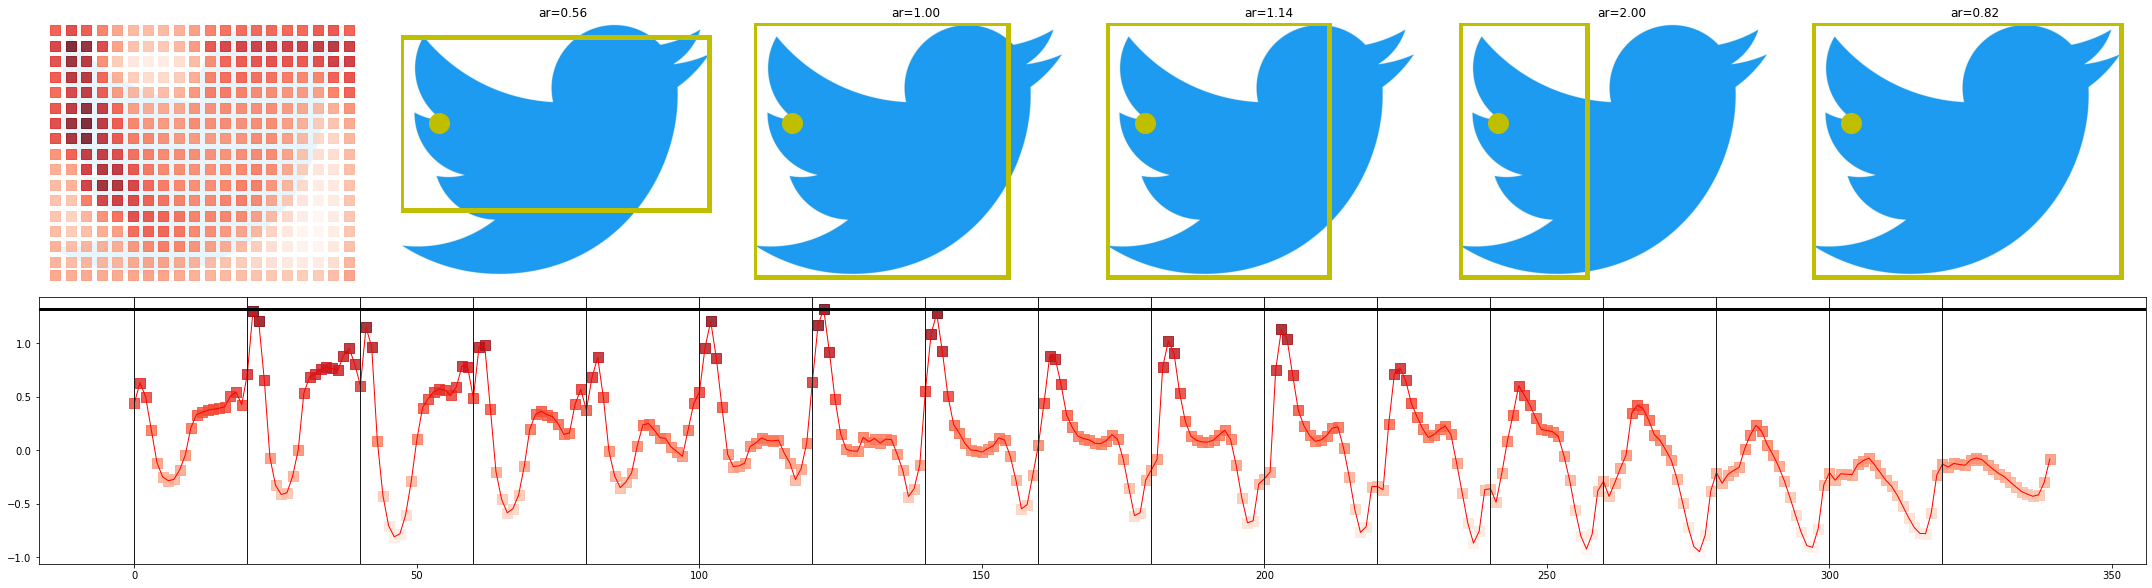

In [8]:
model.plot_img_crops(img_path)

2

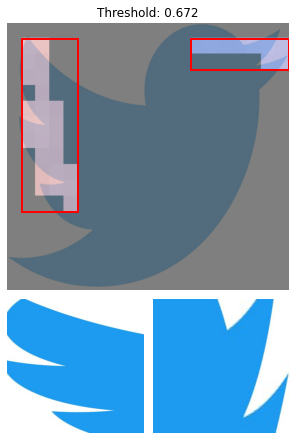

In [9]:
process_image(img_path, model)

In [10]:
with open(img_path, "rb") as fp:
    img_content = base64.b64encode(fp.read())

In [11]:
default_img_content = """data:image/jpg;base64,{}""".format(
    img_content.decode("utf-8").replace("\n", "")
)

In [12]:
STRIP_IMG_PREFIX = re.compile("^data:image/.+;base64,")

def get_plt_fig_contents(fig=None):
    if fig is None:
        fig = plt.gcf()
    pic_IObytes = BytesIO()
    fig.savefig(pic_IObytes, bbox_inches="tight", format="jpg")
    plt.close()
    pic_IObytes.seek(0)
    img_crop_contents = (
        base64.b64encode(pic_IObytes.read()).decode("utf-8").replace("\n", "")
    )
    img_crop_contents = f"data:image/jpg;base64,{img_crop_contents}"
    return img_crop_contents


def get_crop_image(contents):
    contents = STRIP_IMG_PREFIX.sub("", contents)
    img = Image.open(BytesIO(base64.b64decode(contents)))
    model.plot_img_crops_using_img(img)
    img_crop_contents = get_plt_fig_contents(fig=None)
    return img_crop_contents


def parse_contents(contents, filename, date):
    with tempfile.NamedTemporaryFile("w+b") as fp:
        contents = STRIP_IMG_PREFIX.sub("", contents)
        img = Image.open(BytesIO(base64.b64decode(contents)))
        print(fp.name)
        img.save(fp, "JPEG")
        img_path = Path(fp.name)
        model.plot_img_crops(img_path)
        img_crop_contents = get_plt_fig_contents(fig=None)
        process_image(img_path, model)
        img_segment_contents = get_plt_fig_contents(fig=None)

    return html.Div(
        [
            html.H5(filename),
            html.H6(datetime.datetime.fromtimestamp(date)),
            # HTML images accept base64 encoded strings in the same format
            # that is supplied by the upload
            html.Div(
                [html.Img(src=img_crop_contents, height=800)],
                style={"display": "inline-block", "height": "800px"},
            ),
            html.Div(
                [html.Img(src=img_segment_contents, height=500)],
                style={"display": "inline-block", "height": "800px"},
            ),
            html.Hr(),
            html.Div("Raw Content"),
            html.Pre(
                contents[0:200] + "...",
                style={"whiteSpace": "pre-wrap", "wordBreak": "break-all"},
            ),
        ]
    )

In [13]:
# Stylesheet credits: https://codepen.io/chriddyp/pen/bWLwgP
external_stylesheets = ["https://codepen.io/chriddyp/pen/bWLwgP.css"]

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(
    [
        dcc.Upload(
            id="upload-image",
            children=html.Div(["Drag and Drop or ", html.A("Select Files")]),
            style={
                "width": "100%",
                "height": "60px",
                "lineHeight": "60px",
                "borderWidth": "1px",
                "borderStyle": "dashed",
                "borderRadius": "5px",
                "textAlign": "center",
                "margin": "10px",
            },
            # Allow multiple files to be uploaded
            multiple=True,
        ),
        html.Div(
            [
                parse_contents(
                    default_img_content, img_path.name, img_path.stat().st_mtime
                )
            ],
            id="output-image-upload",
        ),
        html.Div(id="output-image-crops"),
    ]
)


@app.callback(
    Output("output-image-upload", "children"),
    [Input("upload-image", "contents")],
    [State("upload-image", "filename"), State("upload-image", "last_modified")],
)
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n, d)
            for c, n, d in zip(list_of_contents, list_of_names, list_of_dates)
        ]
        return children
    return dash.no_update

/tmp/tmp46qdt6ak
None 1034 851


In [14]:
import os

In [15]:
dashboard_url = f"http://localhost:{PORT}"
print(f"Dashboard will be available at: {dashboard_url}. Open the link in browser.")

Dashboard will be available at: http://localhost:9000. Open the link in browser.


In [16]:
import logging
from logging.handlers import RotatingFileHandler

logger = logging.getLogger("Image crop logger")
handler = RotatingFileHandler(
    str(Path("./dash_app.log").expanduser()), maxBytes=10000, backupCount=5
)
logger.addHandler(handler)

In [17]:
logger.warning(f"Starting dashboard at: {dashboard_url}. Open the link in browser.")

In [ ]:
print(f"Access dashboard at: {dashboard_url}")
app.server.logger.addHandler(handler)
app.run_server(
    debug=False, threaded=False, port=PORT, dev_tools_ui=True, host="0.0.0.0"
)

Access dashboard at: http://localhost:9000
Dash is running on http://0.0.0.0:9000/



INFO:__main__:Dash is running on http://0.0.0.0:9000/



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:9000/ (Press CTRL+C to quit)
INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:07] "GET / HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:07] "GET /_dash-component-suites/dash_renderer/react@16.v1_1_2m1576595738.8.6.min.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:07] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_1_2m1576595738.8.6.min.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:07] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_1_2m1576595738.7.2.min.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:08] "GET /_dash-component-suites/dash_core_components/plotly-1.v1_3_1m1576595950.50.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:08] "GET /_dash-component-suites/dash_core_components/highlight.v1_3_1m1576595950.pack.js HTTP/1.1" 200 -
INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:08] "GET /_dash-component-suite

/tmp/tmpa3_5vn9_
None 400 400


INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:17:57] "POST /_dash-update-component HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-pac

ERROR:__main__:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/pyt

/tmp/tmps3u7v0h1
None 470 626


INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:18:35] "POST /_dash-update-component HTTP/1.1" 200 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-pac

ERROR:__main__:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/pyt

/tmp/tmplar8jdqf
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/PIL/JpegImagePlugin.py", line 629, in _save
    rawmode = RAWMODE[im.mode]
KeyError: 'RGBA'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/

ERROR:__main__:Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/PIL/JpegImagePlugin.py", line 629, in _save
    rawmode = RAWMODE[im.mode]
KeyError: 'RGBA'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/home/bahushruth/anaconda3/envs/image-crop-analysis/lib/python3.9/site-packages/flask/_c

/tmp/tmpw75asolw
None 3456 4608


INFO:werkzeug:192.168.0.3 - - [31/Jul/2021 20:19:52] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [31/Jul/2021 20:20:36] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [31/Jul/2021 20:20:36] "GET /_dash-component-suites/dash_renderer/react@16.v1_1_2m1576595738.8.6.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [31/Jul/2021 20:20:36] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_1_2m1576595738.8.6.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [31/Jul/2021 20:20:36] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_1_2m1576595738.7.2.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [31/Jul/2021 20:20:37] "GET /_dash-component-suites/dash_core_components/plotly-1.v1_3_1m1576595950.50.1.min.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [31/Jul/2021 20:20:37] "GET /_dash-component-suites/dash_core_components/highlight.v1_3_1m1576595950.pack.js HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [31/Jul/2021 20:20:38] "GET /_dash-co